Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 413ms/step - accuracy: 0.6169 - loss: 1.0028 - val_accuracy: 0.8458 - val_loss: 0.4075
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 561ms/step - accuracy: 0.9139 - loss: 0.2337 - val_accuracy: 0.9488 - val_loss: 0.1469
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 502s 803ms/step - accuracy: 0.9657 - loss: 0.0970 - val_accuracy: 0.9664 - val_loss: 0.0976
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 396s 633ms/step - accuracy: 0.9753 - loss: 0.0761 - val_accuracy: 0.9272 - val_loss: 0.2267
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 425ms/step - accuracy: 0.9696 - loss: 0.1049 - val_accuracy: 0.9642 - val_loss: 0.1234
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 433s 693ms/step - accuracy: 0.9870 - loss: 0.0443 - val_accuracy: 0.9778 - val_loss: 0.0745
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step - a

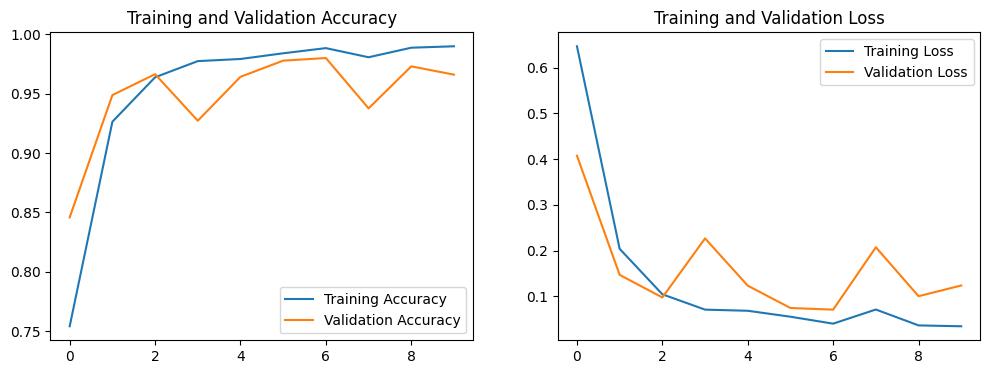

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report

# Path to your dataset
DATASET_PATH = r"C:\Users\kashi\Desktop\LY Project\Multi Cancer\Multi Cancer\Cervical Cancer"

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = val_ds.class_names

# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

# Plotting training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

# Classification Report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
